In [74]:
import pickle
import gensim
import os
import pylab as plt
import numpy as np
import re
import pandas as pd
import seaborn as sb
import itertools
import scipy
from gensim.models.wrappers.dtmmodel import DtmModel

from DTM_Pipeline import Pipeline
import matplotlib.pylab

% matplotlib 
#inline

Using matplotlib backend: MacOSX


In [37]:
# read in data
# make corpus, dictionary etc.
key="Y02E_10_20"
pl = Pipeline(key=key,m_type="DIM",num_topics=5)
pl.make_corpus()

Making dictionary
368.014618874
saving dictionary
0.039705991745
Saving corpus
176.612743139


In [61]:
def get_time_seq(data_file, min_slice_size=None):
    df =  pd.read_csv(data_file)
    # Create dummy column
    df["Y"] = pd.DatetimeIndex(df["appln_filing_date"]).to_period("A")
    # group by dummy column
    groups = df.groupby("Y")
    # return sorted df and counts dict
    df = df.sort_values("appln_filing_date")
    approved_ids = None
    if min_slice_size == None:
        # count members of each group
        counts = np.sort([[key,len(groups.groups[key])] for key in groups.groups.keys()], axis=0)
        time_seq = list(counts[:,1])
    else:
        approved_ids = []
        for group in groups.groups.iteritems():
            if len(group[1]) >= min_slice_size:
                approved_ids.append(df.loc[group[1]]["appln_id"].values[:min_slice_size])
                
        time_seq = [min_slice_size]*len(approved_ids)
    return time_seq, approved_ids, np.unique(df["Y"])

In [62]:
# get time sequence, and approved appln ids
data_file = '../Data/{}.csv'.format(key)
min_slice_size=200
time_seq, approved_ids, times = get_time_seq(data_file, min_slice_size)

## Get original texts
Obtain original texts without stemming/lemmatization etc.

In [35]:
def stream_corp(data_file,approved_ids=None):
    '''generator for iterating through lines of the data
    '''
    # regex for sanitizing the abstracts
    html = re.compile(r'\<[^\>]*\>')
    nonan = re.compile(r'[^a-zA-Z ]')

    # read file one line at a time and sanitize
    for line in pd.read_csv(data_file,sep=',', chunksize=1):
        if approved_ids == None:
            line = line["appln_abstract"].values[0]
            line = nonan.sub(' ',html.sub('',str(line))).lower().split()
            line = stem_doc(line) #apply lemmatization/stemming
            yield dictionary.doc2bow(line)
        else: # if there are approved_ids
            if line["appln_id"].values[0] in approved_ids:
                line = line["appln_abstract"].values[0]
                yield line

In [20]:
key="Y02E_10_20"
data_file = '../Data/{}.csv'.format(key)
all_docs = np.array([line for line in stream_corp(data_file, approved_ids = list(itertools.chain(*approved_ids)))]).reshape((32, 200))

## Run DTM/DIM with optimal paramters

In [38]:
dtm_home = os.environ.get('DTM_HOME', "dtm-master")
dtm_path = os.path.join(dtm_home, 'bin', 'dtm-darwin64') if dtm_home else None

In [41]:
# Run DIM
dim = DtmModel(dtm_path,
               pl.corpus,
               time_seq,
               num_topics=5,
               model="fixed",
               id2word=pl.corpus.dictionary,
               initialize_lda=True,
               lda_sequence_max_iter=32,
               lda_max_em_iter=15)

In [46]:
# DTM
dtm = DtmModel(dtm_path,pl.corpus,time_seq,num_topics=5,
               id2word=pl.corpus.dictionary,initialize_lda=True,
               lda_sequence_max_iter=36,
               lda_max_em_iter=15)

In [75]:
_MODELS_DIR = "saved_models/"
filehandler = open(_MODELS_DIR + "DIM_Topic_Validation" + ".obj","wb")
pickle.dump(dim,filehandler)
filehandler.close()

filehandler = open(_MODELS_DIR + "DTM_Topic_Validation" + ".obj","wb")
pickle.dump(dtm,filehandler)
filehandler.close()

## Get topic distributions throughout time

In [47]:
def topic_frames(topics,n_tops):
    # topics = lda.print_topics(topics=20, times=46, topn=10)
    topic_dfs = {}
    # separate topics out from list
    for i in range(n_tops):
        topic = topics[i::n_tops]
        n_words = len(topic[0].split("+"))
        n_slices = len(topic)
        temp_top = " ".join(topic)
        words = [k for k in re.split("[^a-zA-Z]*", temp_top) if k!= '']
        coeffs = re.findall(r"[-+]?\d+[\.]?\d*", temp_top)
        Z = zip(coeffs,words)
        # get all unique words in topic
        columns = np.unique(words)
        Z = [Z[k:k+n_words] for k in xrange(0, len(Z), n_words)]
        df = []
        for j in range(len(Z)):
            temp = []
            row = np.array(Z[j])[:,1]
            for word in columns:
                if word in row:
                    # append its associated number
                    idx = np.where(row == word)[0][0]
                    temp.append(float(np.array(Z[j])[idx,0]))
                else:
                    # append NaN
                    temp.append(np.NaN)
            df.append(temp)
        topic_dfs["topic_"+str(i+1)] = pd.DataFrame(df)
        topic_dfs["topic_"+str(i+1)].columns = columns
    return topic_dfs


In [83]:
topics = dtm.show_topics(topics=5, times=32, topn=20)

In [84]:
topic_dfs = topic_frames(topics, n_tops=5)
topic_dfs

{'topic_1':     arrange  bearing  blade   body  comprise  constitution  cover  device  \
 0       NaN      NaN  0.020    NaN       NaN           NaN  0.010     NaN   
 1       NaN      NaN  0.021    NaN       NaN           NaN  0.010     NaN   
 2       NaN      NaN  0.023    NaN       NaN           NaN  0.009     NaN   
 3       NaN      NaN  0.024    NaN       NaN           NaN  0.009     NaN   
 4       NaN    0.008  0.024    NaN       NaN           NaN  0.008     NaN   
 5       NaN    0.008  0.023    NaN       NaN           NaN  0.008     NaN   
 6       NaN    0.009  0.021    NaN       NaN           NaN  0.008     NaN   
 7       NaN    0.009  0.018    NaN       NaN           NaN  0.009     NaN   
 8       NaN    0.009  0.017    NaN       NaN         0.008  0.009     NaN   
 9       NaN    0.009  0.016    NaN       NaN         0.009  0.009     NaN   
 10      NaN    0.009  0.015    NaN       NaN         0.009  0.008     NaN   
 11      NaN    0.009  0.016    NaN       NaN        

## Get influences of all documents

In [50]:
dim.influences_time[0].shape

(200, 5)

In [52]:
document_no = 5 #document 2
topic_no = 2 #topic number 2
time_slice = 4 #time slice 1
dim.influences_time[time_slice][document_no][topic_no]

-0.0010492118658467118

## Get topic vectors for all documents

In [53]:
dtm_doc_dists = dtm.gamma_
dim_doc_dists = dim.gamma_

## Get actual labels for all documents

In [54]:
# flattened list of approved appln_ids
flat_ids = list(itertools.chain(*approved_ids))

In [55]:
# get the cpc subclass that each document belongs to as 'true labels'
data = pd.read_csv(data_file)
true_labels = []
for i in range(len(data)):
    if data["appln_id"].values[i] in flat_ids:
        true_labels.append(float(data["cpc_class_symbol"].values[i][9:]))
del data

## Plot Topic Word Distribution

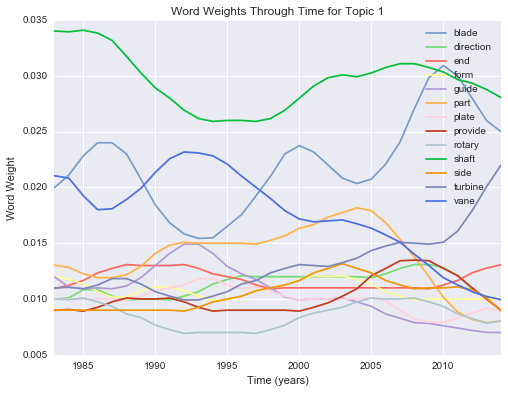

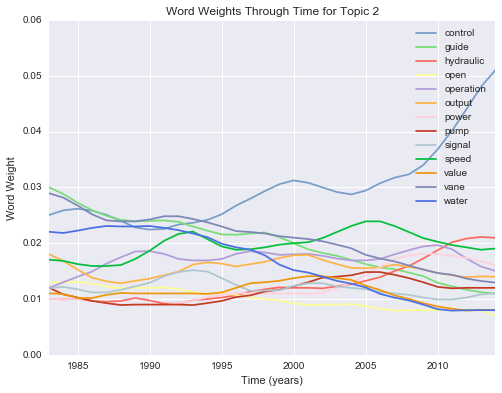

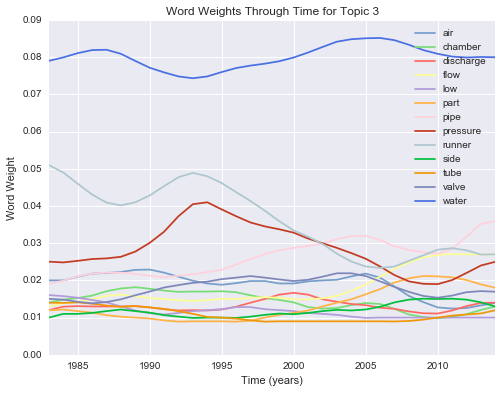

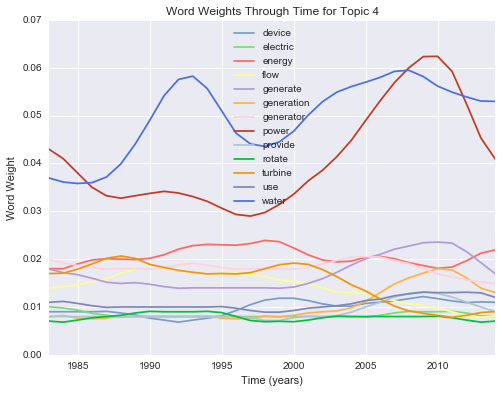

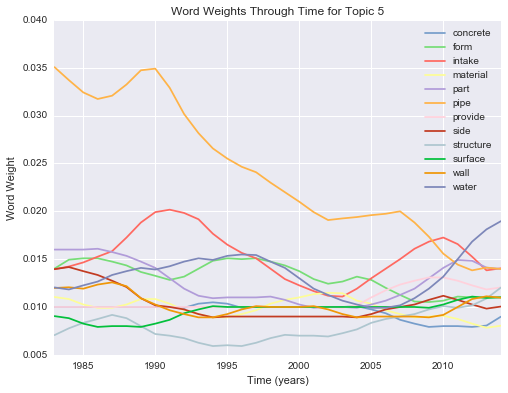

In [90]:
# pick a topic with interesting word distributions and plot
for tnum in [1,2,3,4,5]:
    temp = topic_dfs["topic_{}".format(tnum)].interpolate(method='linear', axis=0, limit=4).dropna(axis=1)
    # smooth it before plotting
    for col in temp.columns.values:
        temp[col] = scipy.signal.savgol_filter(temp[col],5,3)

    #pl = ["#11c638", "#8dd593", "#d5eae7", "#f3e1eb", "#f6c4e1", "#c6dec7",
    #      "#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", 
    #      "#4a6fe3", "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a", 
    #      "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#f79cd4"]
    #temp_pl = sb.color_palette("RdYlGn", 10)
    
    pl = ["#779ECB","#77DD77","#FF6961","#FDFD96","#B19CD9","#FFB347","#FFD1DC",
          "#C23B22","#AEC6CF","#03C03C","#ef9708","#7d87b9","#4a6fe3","#e07b91","#d33f6a"]

    temp.index = times[-32:]
    temp.index = temp.index.to_datetime()
    
    sb.set_palette(pl)
    temp.plot(figsize=(8,6))
    plt.xlabel("Time (years)")
    plt.ylabel("Word Weight")
    plt.title("Word Weights Through Time for Topic {}".format(tnum))
    plt.show()

## Print out the top N words of a distribution pr. epoch

In [95]:
raw_topics = [" ".join(re.findall("[a-zA-Z]+", topics[i])).split() for i in range(len(topics))]
len(raw_topics[0::5]) # topic 1

32

## Find documents with highest influence pr. epoch

In [98]:
influences = np.array(dim.influences_time)

In [100]:
influences[time_slice][document_no][topic_no]

-0.0010492118658467118

In [112]:
print(np.argmax(influences[0,:,2]))
print(influences[0,165,2])

165
0.0170571644607


In [110]:
np.array(approved_ids)[0,165]

40233880

In [111]:
all_docs[0,165]

'PURPOSE:To enhance the power of a hydraulic turbine by permitting the flow-in water to run against the lower part of a runner to drive it into rotation and thereby utilizing the head of flow-in water effectively. CONSTITUTION:A casing 11 has such an internal configuration as to guide the flow-in water downward along a locus as a convax curve. A guide vane 16 pivoted rotatably on a shaft 15 is installed at the inlet part for flow-in water, and the amount of water running against a runner 12 is adjusted by turning this guide vane 16. The water flows down in a pipe 10 and is guided to said casing 11 to rotate a runner 14, and thereafter discharged to the water releasing surface 17.'

In [1]:
# look at original document and see if it is actually that important

In [ ]:
# see what the history of each of these patents was

In [ ]:
# pick a cpc class label. Get all doc vectors for each document in this class and group by epoch

In [ ]:
# plot cumulative area chart with topics. 
# If it's intersting, keep optimal parameters. If it's garbage, set k=number of cpc classes.